In [1]:
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset,OutputVis
from detectron2.utils.colormap import random_color

import numpy as np
import matplotlib.pyplot as plt


In [2]:
#spacing
D = 5760 #um
d = D/48 #um scan spacing

P = 1024 #px scan width in pixels = D
dpx = d*P/D #px scan spacing in pixels

In [3]:
dataset_name = 'test'
DatasetCatalog.register(dataset_name, grab_dataset(dataset_name))
MetadataCatalog.get(dataset_name).thing_classes = ["rpd"]

In [4]:
vis =OutputVis(dataset_name,pred_mode='file',pred_file = 'output_test/coco_instances_results.json')
#imggt,imgdt = vis.get_image('101113_OS_oct-024.png')

In [5]:
def compare_enface(grp,name):

    fig, ax = plt.subplots(1,2,figsize=[18,9],dpi=120)
    enface = np.zeros((P,P,3),dtype=int)
    for i,imgid in enumerate(grp.index):
        pos = int(np.clip(np.floor(dpx*i),0,P-1))


        outputs = vis.get_outputs_from_file(imgid,(496,1024))
        outputs = outputs[outputs.scores>.5]
        instances = outputs.pred_boxes[:,(0,2)].round().clip(0,P-1).to(np.int)

        for inst in instances:
            try:
                enface[max(pos-4,0):min(pos+4,P-1),inst[0]:inst[1]]=np.array([255,255,255])#random_color(rgb = True)
            except(IndexError):
                print( pos, inst[0],inst[1])
        
        
    ax[0].imshow(enface)
    ax[0].set_title(str(name) + ' DT')
    ax[0].set_aspect('equal')


    minx = 1024
    enface = np.zeros((P,P,3),dtype=int)
    for i,imgid in enumerate(grp.index):
        pos = int(np.clip(np.floor(dpx*i),0,P-1))

        instances =  vis.get_gt_image_data(imgid)['annotations']
        for inst in instances:
            x1= inst['bbox'][0]
            minx = min(minx,x1)
            x2 = x1 + inst['bbox'][2]
            try:
                enface[max(pos-4,0):min(pos+4,P-1),x1:x2]=np.array([255,255,255])#random_color(rgb = True)
            except(IndexError):
                print( pos, x1,x2)
        
        
    ax[1].imshow(enface)
    ax[1].set_title(str(name) + ' GT')
    ax[1].set_aspect('equal')
    print(minx)
    return fig,ax

In [5]:
import pandas as pd
dfimg = pd.read_csv('output_test/dfimg_test.csv',index_col=0)
grps = dfimg.groupby(['ptid','eye'])


In [15]:
name = (101109,'OD')
imageids = grps.get_group(name).sort_index().index
vis.output_to_pdf(imageids,'output_test/101109_OD.png',grps.get_group(name).sort_index())

100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


In [6]:
gt,dt = vis.get_image('101109_OD_oct-033.png')
ori = vis.get_ori_image('101109_OD_oct-033.png')


In [9]:
from PIL import Image
hcrange = list(vis.height_crop_range(np.array(ori.convert('L')),height_target=256*3))

im = Image.fromarray(np.concatenate((np.array(ori.convert('RGB'))[hcrange,:],np.array(gt)[hcrange,:],np.array(dt)[hcrange])))
im.save('output_test/101109_OD_oct-033.jpg')

In [ ]:

def mygen(grps):
    for name,grp in grps:
        grp = grps.get_group(name).sort_index()
        yield compare_enface(grp,name)
  

gen = mygen(grps)

154


(<Figure size 2160x1080 with 2 Axes>,
 array([<AxesSubplot:title={'center':"(101251, 'OD') DT"}>,
        <AxesSubplot:title={'center':"(101251, 'OD') GT"}>], dtype=object))

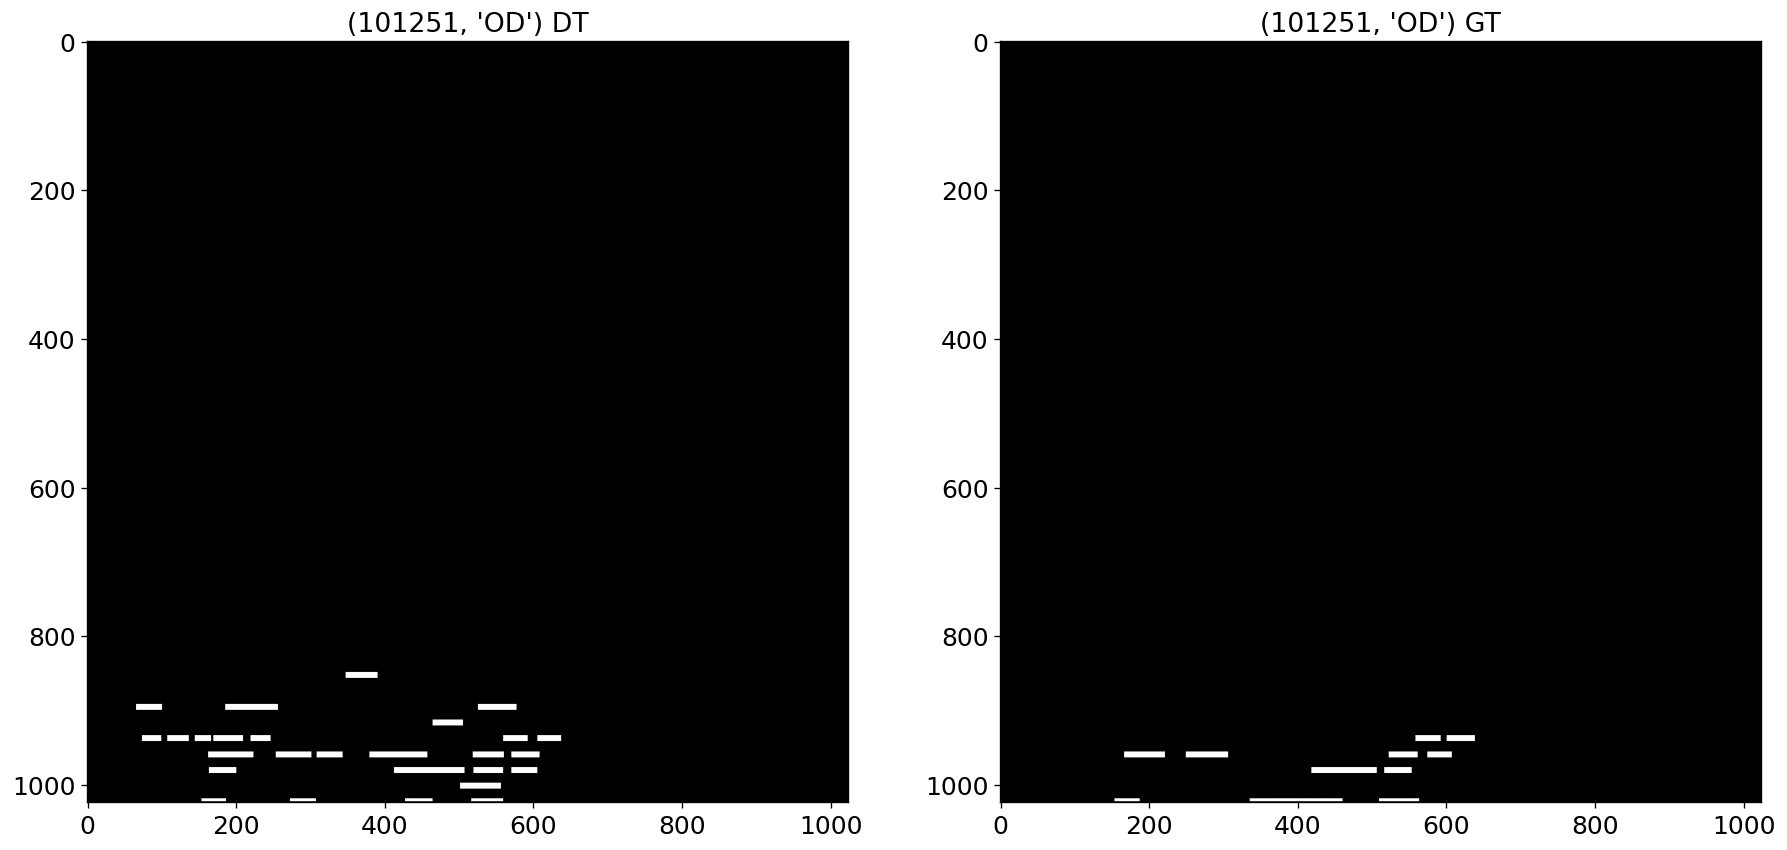

In [123]:
next(gen)

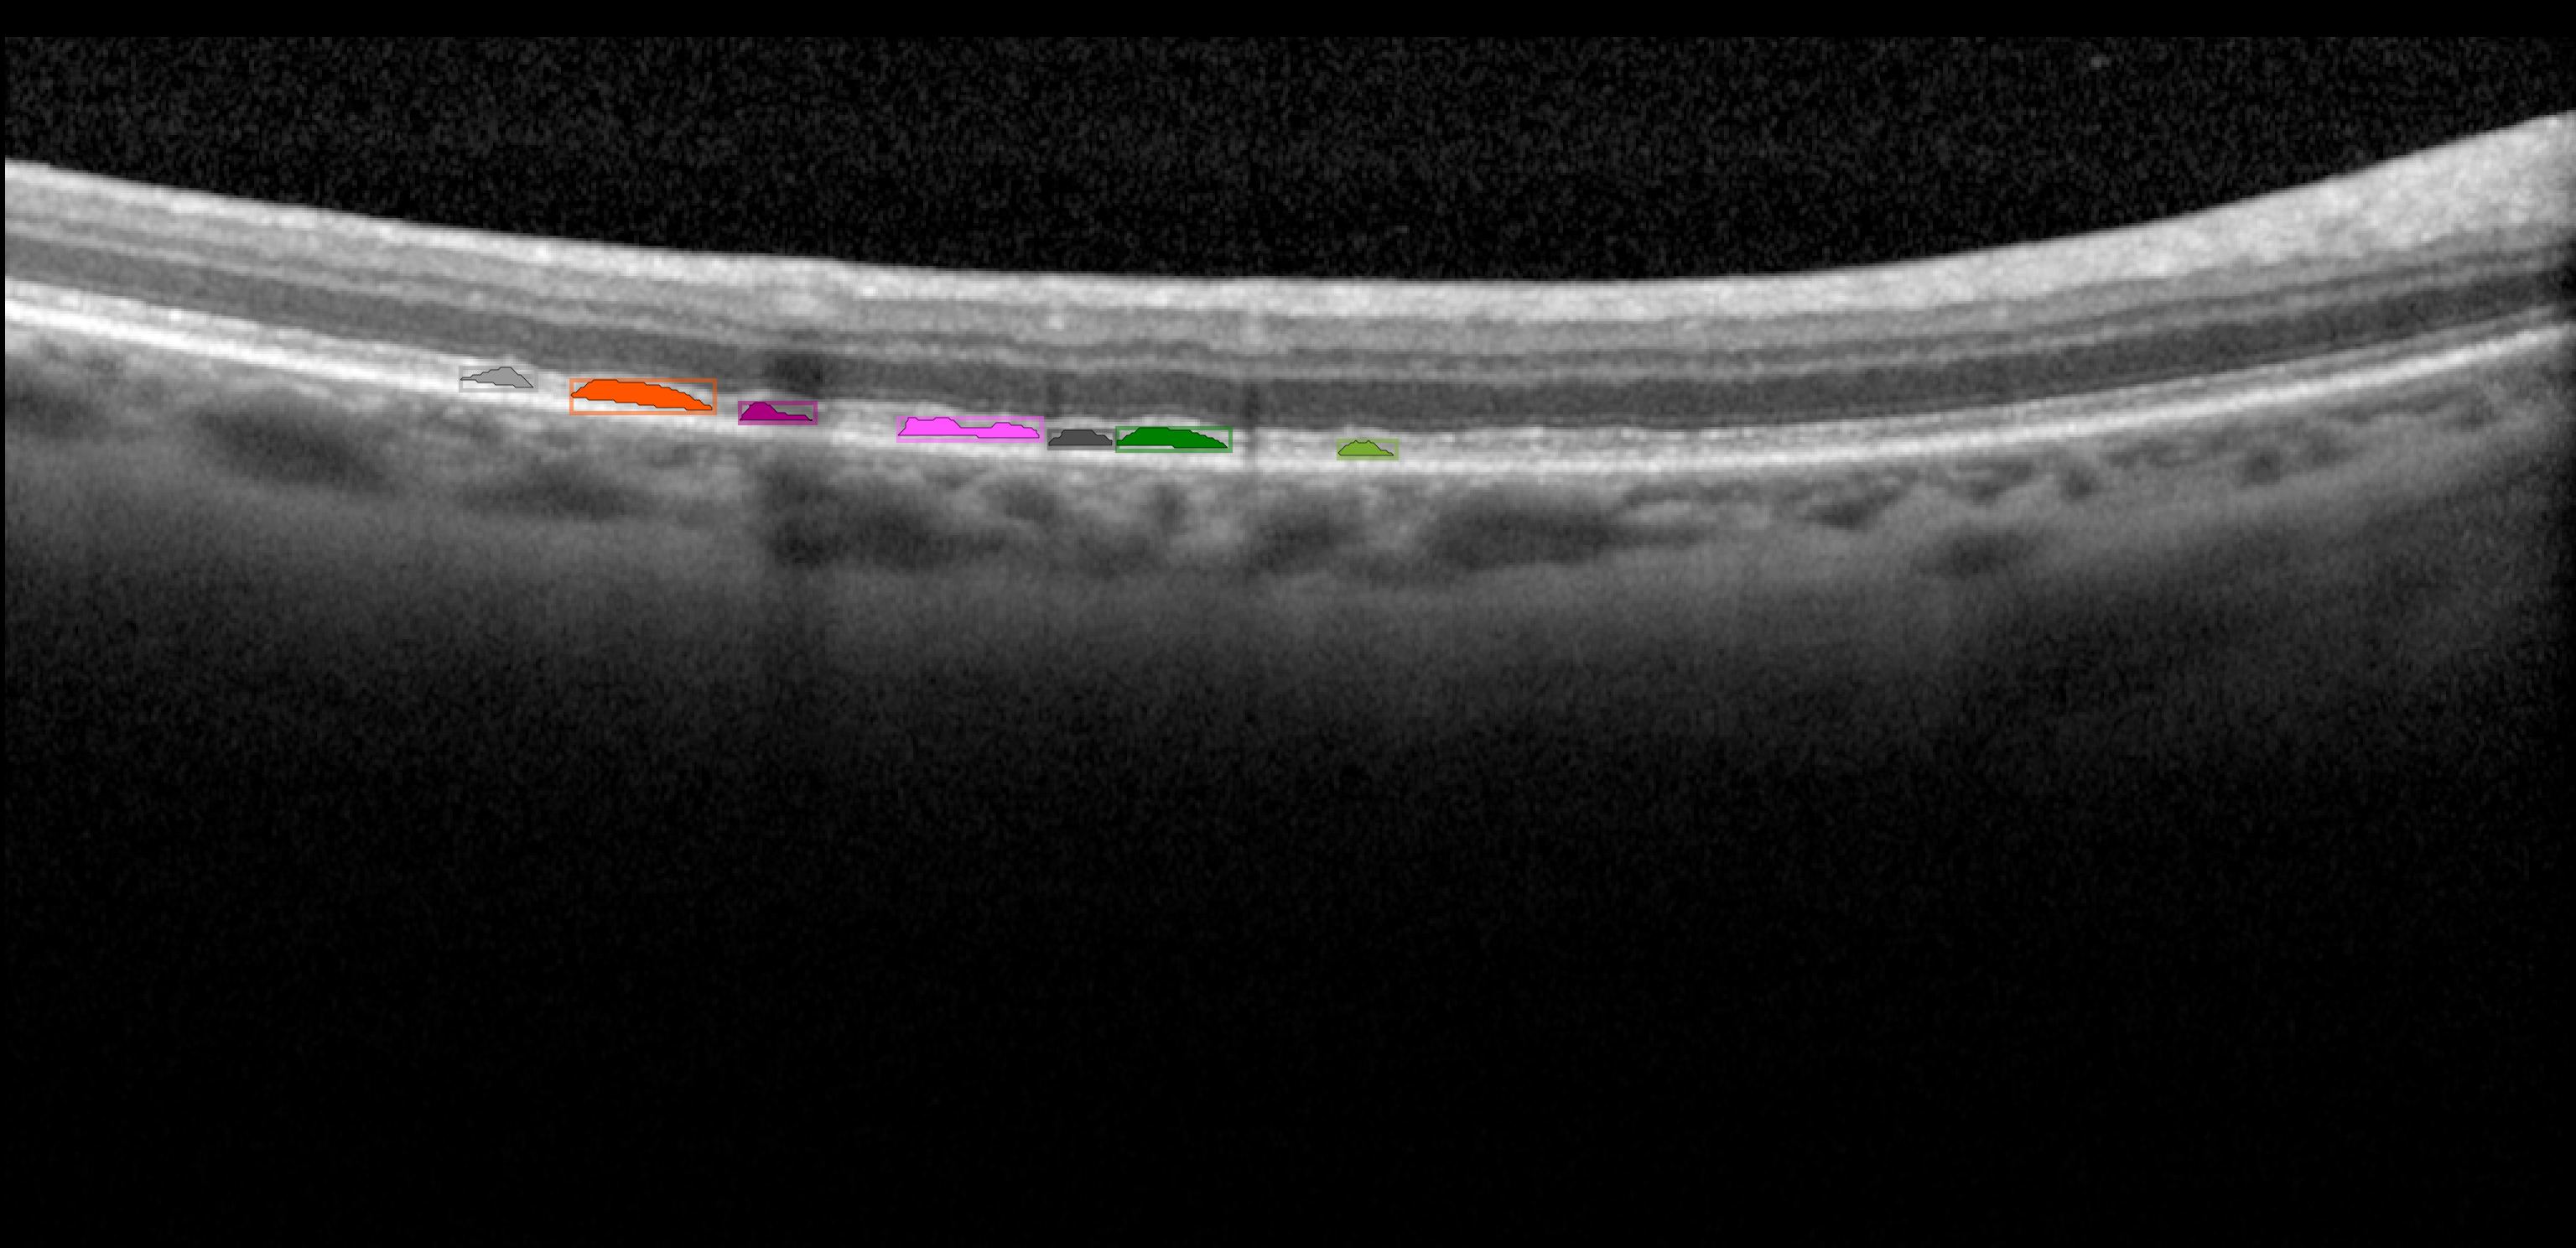

In [70]:
vis.get_image(imgid)[0]